In [1]:
import imprint.nb_util as nb_util
nb_util.setup_nb()

import time
import jax
import jax.numpy as jnp
from jax.scipy.special import expit, logit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import confirm.models.wd41 as wd41
import imprint as ip

## Exploring

We have two subgroups, each split equally into treatment and control arms:
- $p_{\mathrm{TNBC}}^{c}$ - TNBC subgroup control arm effectiveness.
- $p_{\mathrm{TNBC}}^{t}$ - TNBC subgroup treatment arm effectiveness.
- $p_{\mathrm{HR+}}^{c}$ - HR+ subgroup control arm effectiveness.
- $p_{\mathrm{HR+}}^{t}$ - HR+ subgroup treatment arm effectiveness.
  
$f_{\mathrm{TNBC}}$ is the fraction of patients in the TNBC subgroup.

The null hypotheses here are:

$$
p_{\mathrm{TNBC}}^{c} > p_{\mathrm{TNBC}}^{t}
$$

$$
f_{\mathrm{TNBC}} p_{\mathrm{TNBC}}^{c} + (1 - f_{\mathrm{TNBC}}) p_{\mathrm{HR+}}^{c} > 
f_{\mathrm{TNBC}} p_{\mathrm{TNBC}}^{t} + (1 - f_{\mathrm{TNBC}}) p_{\mathrm{HR+}}^{t}
$$

In [2]:
m = wd41.WD41(0, 1)

In [3]:
p_tnbc_c = 0.34
p_hrplus_c = 0.23
S = np.linspace(0, 0.3, 7)
Sbar = np.linspace(0, 0.2, 3)
SS = np.stack(np.meshgrid(S, Sbar, indexing='ij'), axis=-1).reshape(-1, 2)
t_tnbc_t = logit(p_tnbc_c + SS[:, 0])
t_tnbc_c = np.full_like(t_tnbc_t, logit(p_tnbc_c))
t_hrplus_t = logit(p_hrplus_c + SS[:, 1])
t_hrplus_c = np.full_like(t_hrplus_t, logit(p_hrplus_c))
theta = np.stack((t_tnbc_c, t_tnbc_t, t_hrplus_c, t_hrplus_t), axis=-1)

In [4]:
K = 100000
np.random.seed(0)
unifs = np.random.uniform(size=(K, m.unifs.shape[1]))
info = m.sim_jit(unifs, theta, True)

In [5]:
df = pd.DataFrame(SS, columns=['Effect S', 'Effect Sbar'])
df['Effect F'] = 0.54 * df['Effect S'] + 0.46 * df['Effect Sbar']
df['Power'] = np.sum((info['tnbc_stat'] < 0.025) | (info['full_stat'] < 0.025), axis=1) / K
df['P(Reject F)'] = np.sum(info['full_stat'] < 0.025, axis=1) / K
df['P(Reject S)'] = np.sum(info['tnbc_stat'] < 0.025, axis=1) / K
df['P(Select F)'] = np.sum(info['hypofull_live'], axis=1) / K
df['P(Select S)'] = np.sum(info['hypotnbc_live'], axis=1) / K
df['P(Select 1 set)'] = np.sum((~info['hypotnbc_live']) | (~info['hypofull_live']), axis=1) / K
df['P(Enrichment)'] = 1 - df['P(Select F)']
df.set_index(np.arange(1, 22), inplace=True)
df

,Effect S,Effect Sbar,Effect F,Power,P(Reject F),P(Reject S),P(Select F),P(Select S),P(Select 1 set),P(Enrichment)
1,0.00,0.0,0.000,0.01540,0.00842,0.01247,0.93069,0.93116,0.13815,0.06931
2,0.00,0.1,0.046,0.06187,0.05894,0.01898,0.98234,0.78179,0.23587,0.01766
3,0.00,0.2,0.092,0.23860,0.23775,0.02424,0.99661,0.54525,0.45814,0.00339
4,0.05,0.0,0.027,0.06596,0.02866,0.05980,0.87166,0.96481,0.16353,0.12834
5,0.05,0.1,0.073,0.15123,0.13527,0.07563,0.96001,0.86306,0.17693,0.03999
6,0.05,0.2,0.119,0.39804,0.39376,0.09158,0.99133,0.66747,0.34120,0.00867
7,0.10,0.0,0.054,0.19779,0.07474,0.18818,0.78524,0.98363,0.23113,0.21476
8,0.10,0.1,0.100,0.31234,0.25935,0.21358,0.92164,0.92054,0.15782,0.07836
9,0.10,0.2,0.146,0.58088,0.56537,0.24112,0.97906,0.77381,0.24713,0.02094
10,0.15,0.0,0.081,0.41693,0.14441,0.40811,0.67496,0.99293,0.33211,0.32504


In [6]:
df.to_csv('wd41.csv')

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000


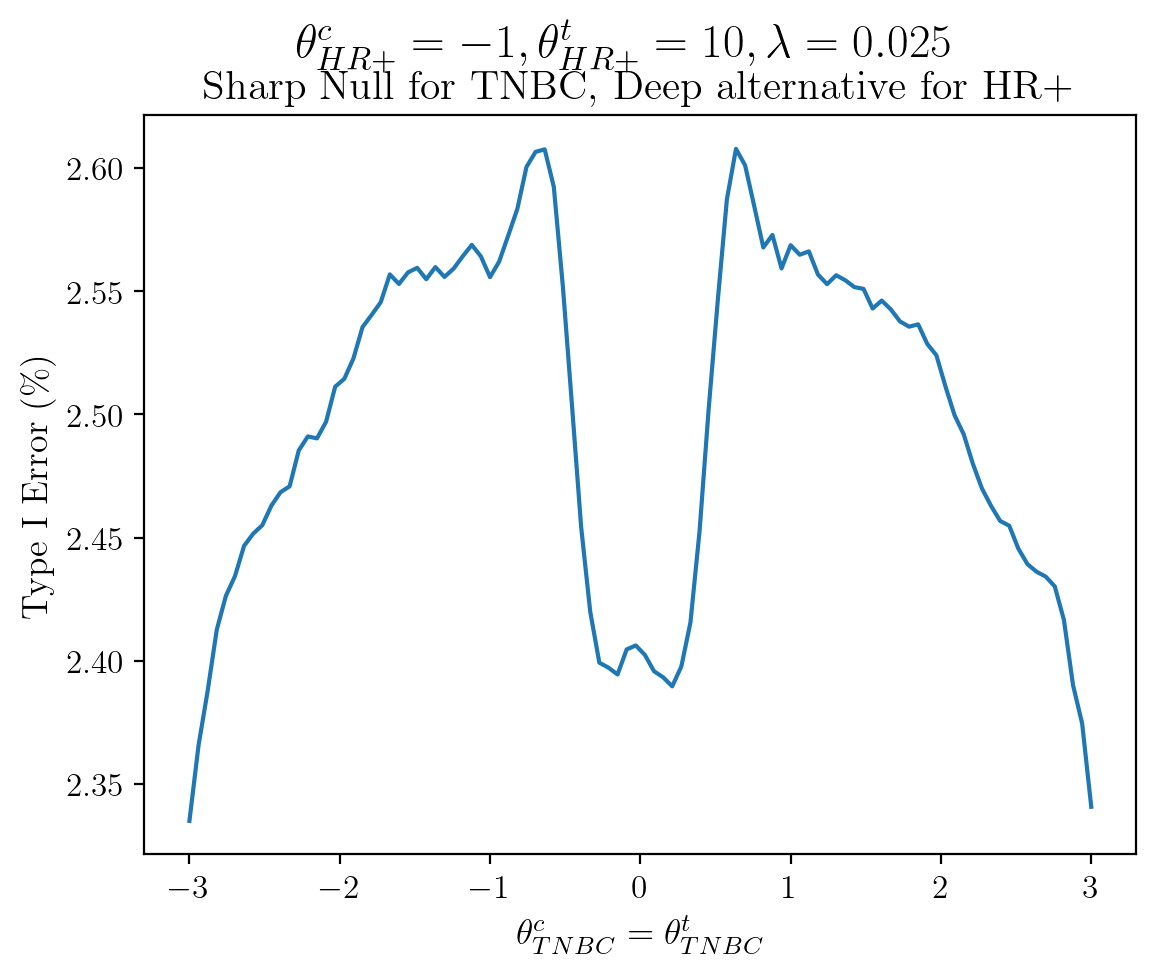

In [10]:
theta0 = np.linspace(-3, 3, 100)
theta1 = theta0
theta2 = np.full_like(theta0, -1)
theta3 = np.full_like(theta0, 10)
theta = np.stack((theta0, theta1, theta2, theta3), axis=-1)
nt0 = np.ones_like(theta0)
nt1 = np.zeros_like(theta0)
null_truth = np.stack((nt0, nt1), axis=-1)

tie_sum = np.zeros_like(theta0)
nsims = 0
for i in range(50):
    unifs = np.random.random(size=(100000, m.unifs.shape[1]))
    stats, _ = m.sim_jit(unifs, theta, False)
    tie_sum += (stats < 0.025).sum(axis=1)
    nsims += unifs.shape[0]
    print(nsims)

tie_est = tie_sum / nsims
plt.plot(theta0, 100 * tie_est)
plt.xlabel(r'$\theta_{TNBC}^c = \theta_{TNBC}^t$')
plt.ylabel('Type I Error (\%)')
plt.title(r'Sharp Null for TNBC, Deep alternative for HR+')
plt.suptitle(r'$\theta_{HR+}^c = -1, \theta_{HR+}^t = 10, \lambda = 0.025$')
plt.show()

## Simple grids

In [11]:
theta_tnbc_c = -1
p_tnbc_c = expit(theta_tnbc_c)
theta_hrplus_c = -1
p_hrplus_c = expit(theta_hrplus_c)


def get_theta(theta):
    t_tnbc_t = theta[..., 0]
    return jnp.stack(
        (
            jnp.full_like(t_tnbc_t, theta_tnbc_c),
            t_tnbc_t,
            jnp.full_like(t_tnbc_t, theta_hrplus_c),
            theta[..., 1],
        ),
        axis=-1,
    )


class WD41Null2D(wd41.WD41Null):
    def get_theta(self, theta):
        return get_theta(theta)


class WD412D(wd41.WD41):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.family_params = {
            "n": jnp.array(
                [
                    self.n_max_tnbc,
                    self.n_max_hrplus,
                ]
            )
        }

    def sim_batch(
        self,
        begin_sim: int,
        end_sim: int,
        theta: jnp.ndarray,
        null_truth: jnp.ndarray,
        detailed: bool = False,
    ):
        return super().sim_batch(
            begin_sim,
            end_sim,
            get_theta(theta),
            null_truth,
            detailed,
        )


model = WD412D(0, 100000)
nulls = [ip.hypo("-1 > theta0"), WD41Null2D(model.true_frac_tnbc)]

grid = ip.cartesian_grid([-2.5, -2.5], [-0.0, -0.0], n=[90, 90], null_hypos=nulls)


DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=8100, worker_id=1, t=1677611668, n_bits=18, worker_bits=18) = [4604131548911108096 4604131548911108097 4604131548911108098, ...]:
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=338, worker_id=1, t=1677611669, n_bits=18, worker_bits=18) = [4604131617630584832 4604131617630584833 4604131617630584834, ...]:


In [12]:
val_df = ip.validate(WD412D, g=grid, lam=0.025, K=10000)

In [13]:
theta = grid.get_theta()
p = expit(theta)
f = model.true_frac_tnbc
ptt = expit(np.linspace(-2.5, theta[:,1].max(), 100))
pht = ((p_tnbc_c * f + p_hrplus_c * (1 - f)) - (ptt * f)) / (1 - f)

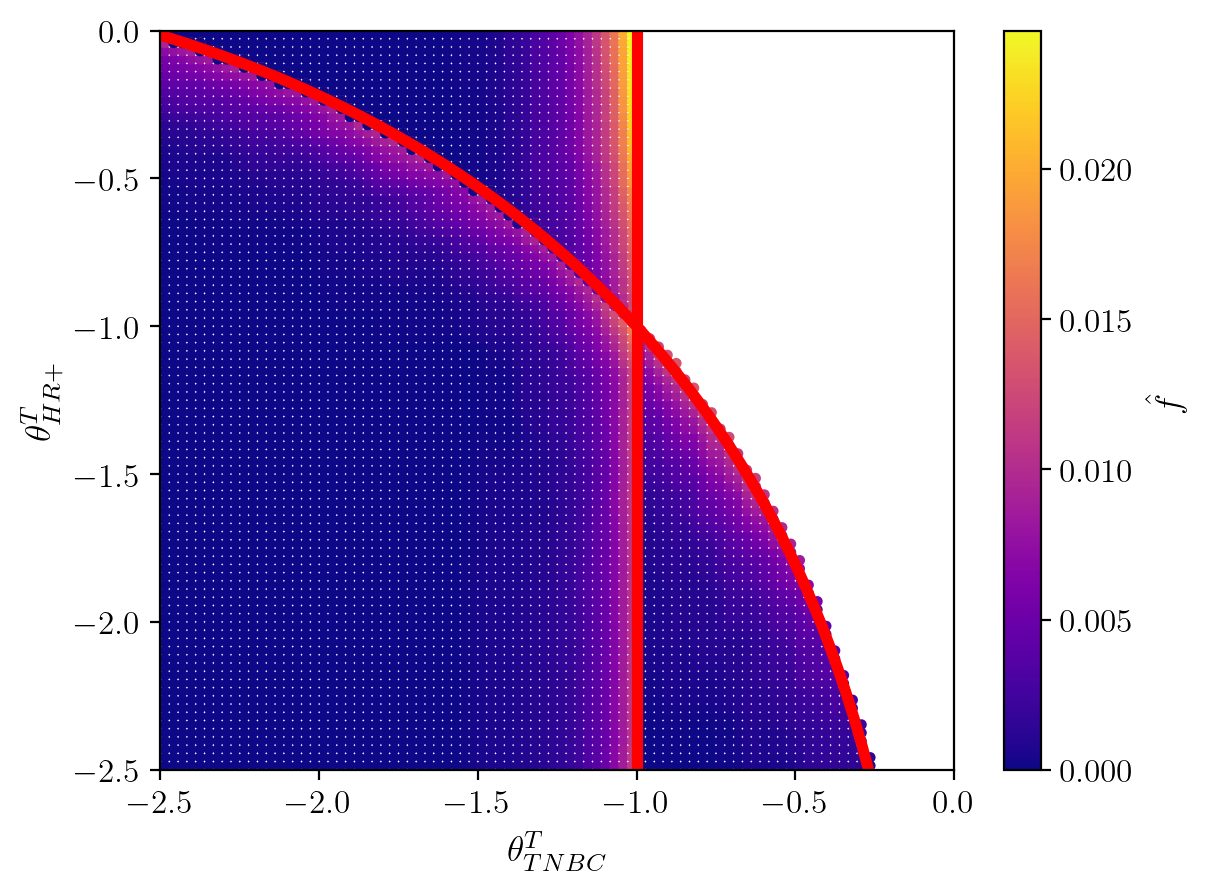

In [14]:
plt.scatter(theta[:,0], theta[:,1], c=val_df['tie_est'], s=8)
plt.axvline(theta_tnbc_c, color='red', linewidth=4)
plt.plot(logit(ptt), logit(pht), color='red', linewidth=4)
cbar = plt.colorbar()
cbar.set_label('$\hat{f}$')
plt.xlabel(r'$\theta_{TNBC}^{T}$')
plt.ylabel(r'$\theta_{HR+}^{T}$')
plt.xlim([-2.5, 0.0])
plt.ylim([-2.5, 0.0])
plt.show()

In [15]:
cal_df = ip.calibrate(WD412D, g=grid, alpha=0.025, K=10000)

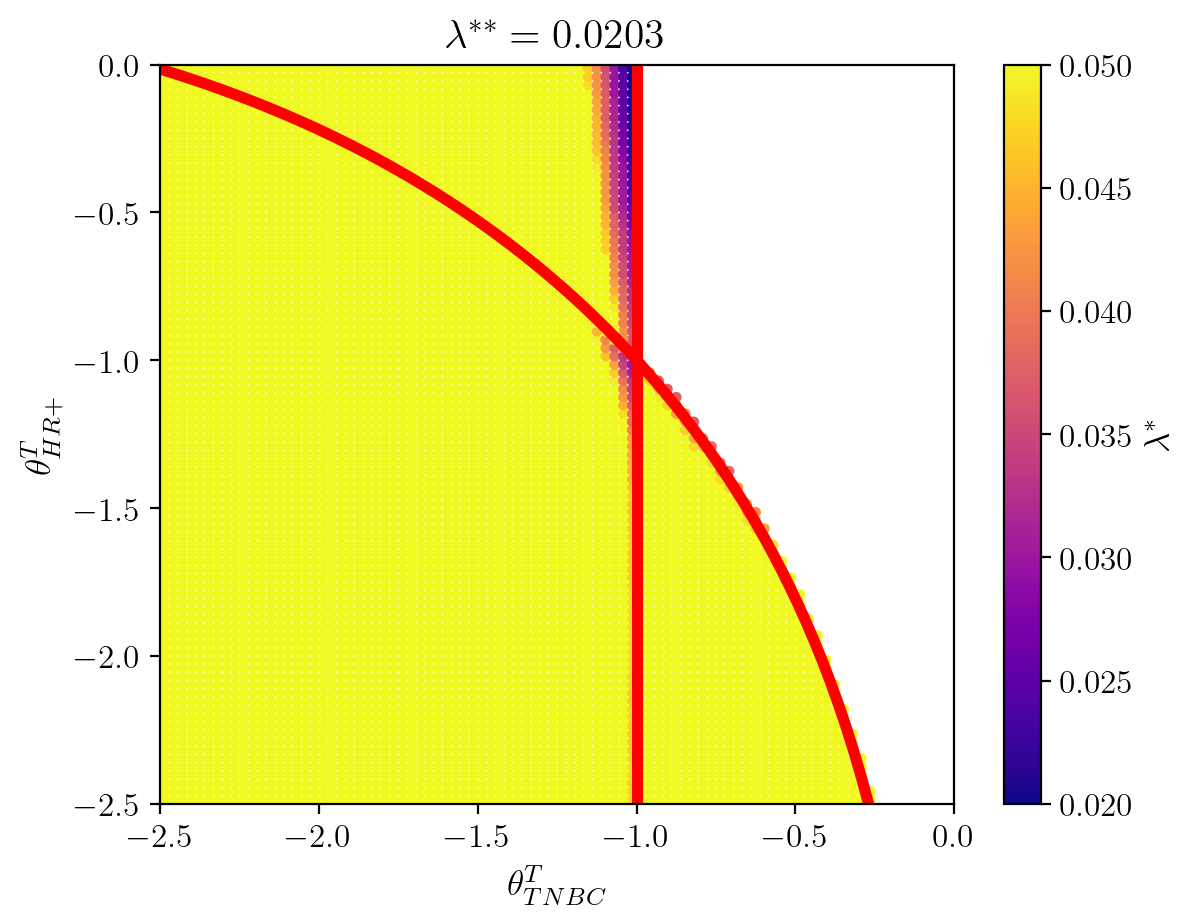

In [16]:
plt.scatter(theta[:,0], theta[:,1], c=cal_df['lams'], s=8, vmin=0.02, vmax=0.05)
plt.axvline(theta_tnbc_c, color='red', linewidth=4)
plt.plot(logit(ptt), logit(pht), color='red', linewidth=4)
cbar = plt.colorbar()
cbar.set_label('$\lambda^{*}$')
plt.xlabel(r'$\theta_{TNBC}^{T}$')
plt.ylabel(r'$\theta_{HR+}^{T}$')
plt.xlim([-2.5, 0.0])
plt.ylim([-2.5, 0.0])
plt.title('$\lambda^{**}='+f'{cal_df["lams"].min():.4f}$')
plt.show()

## Bigger job

In [17]:
from confirm.adagrid import ada_calibrate

In [18]:
grid = ip.cartesian_grid(
    [-2.5, -2.5],
    [1.0, 1.0],
    n=[10, 10],
    null_hypos = nulls
)

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=100, worker_id=1, t=1677611699, n_bits=18, worker_bits=18) = [4604133679214886912 4604133679214886913 4604133679214886914, ...]:
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=20, worker_id=1, t=1677611700, n_bits=18, worker_bits=18) = [4604133747934363648 4604133747934363649 4604133747934363650, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=30, worker_id=1, t=1677611701, n_bits=18, worker_bits=18) = [4604133816653840384 4604133816653840385 4604133816653840386, ...]:


In [19]:
db = ada_calibrate(
    WD412D,
    g=grid,
    alpha=0.025,
    bias_target=0.0005,
    grid_target=0.0005,
    std_target=0.0015,
    calibration_min_idx=80,
    step_size=2**13,
    packet_size=2**12,
    overrides=dict(
        bias_target=0.0005,
        grid_target=0.0005,
        std_target=0.0015
    )
)

/workspaces/confirmasaurus/confirm/adagrid/adagrid.py:236: UserWarning: Overrides are ignored when starting a new job.
  warnings.warn("Overrides are ignored when starting a new job.")
DEBUG:confirm.adagrid.adagrid:first step (0, 0, 1, 69) n_tiles=69 packet_size=4096
DEBUG:confirm.adagrid.adagrid:Starting loop 0.
DEBUG:confirm.adagrid.adagrid:Claimed DB lock.
DEBUG:confirm.adagrid.adagrid:get_work(step_id=0, step_iter=0)
DEBUG:confirm.adagrid.adagrid:get_work(...) returned 69 tiles.
DEBUG:confirm.adagrid.adagrid:Processing 69 tiles.
DEBUG:confirm.adagrid.adagrid:{'n_processed': 69,
 'runtime_full_iter': '3.902965',
 'runtime_get_work': '0.001390',
 'runtime_processing': '3.875474',
 'runtime_update_step_info': '0.001048',
 'runtime_wait_for_lock': '0.000522',
 'status': 'WORK',
 'step_id': 0,
 'step_iter': 0,
 'step_n_iter': 1,
 'step_n_tiles': 69,
 'waitings': 0,
 'work_extraction_time': '1677611719.132849',
 'worker_id': 2,
 'worker_iter': 0}
DEBUG:confirm.adagrid.adagrid:Starting lo

In [20]:
g_r = ip.grid.Grid(db.get_results(), None).prune_inactive()

In [21]:
g_r.n_tiles

74867

In [27]:
B_lams = np.array([g_r.df[f'B_lams{i}'].min() for i in range(50)])
lamss = g_r.df['lams'].min()
B_lams, lamss, B_lams.mean(), lamss - B_lams.mean()

(array([0.02322953, 0.02448712, 0.02272768, 0.02422191, 0.02335166, 0.02298104, 0.0246517 ,
        0.02420482, 0.02431205, 0.02435009, 0.02410076, 0.02438638, 0.02476646, 0.02428911,
        0.02359362, 0.02340358, 0.02372574, 0.02410076, 0.02405344, 0.0226883 , 0.02272768,
        0.02422191, 0.02448102, 0.02405344, 0.02435009, 0.02326829, 0.0234539 , 0.024524  ,
        0.02340358, 0.02385168, 0.0233657 , 0.02433424, 0.02390663, 0.02392645, 0.02360044,
        0.02424303, 0.02392645, 0.02301798, 0.02359362, 0.02228755, 0.02359362, 0.02326829,
        0.02322953, 0.02322953, 0.02448712, 0.0233657 , 0.02359362, 0.02326829, 0.02410076,
        0.02360044], dtype=float32),
 0.023725737,
 0.023758003,
 -3.2266602e-05)

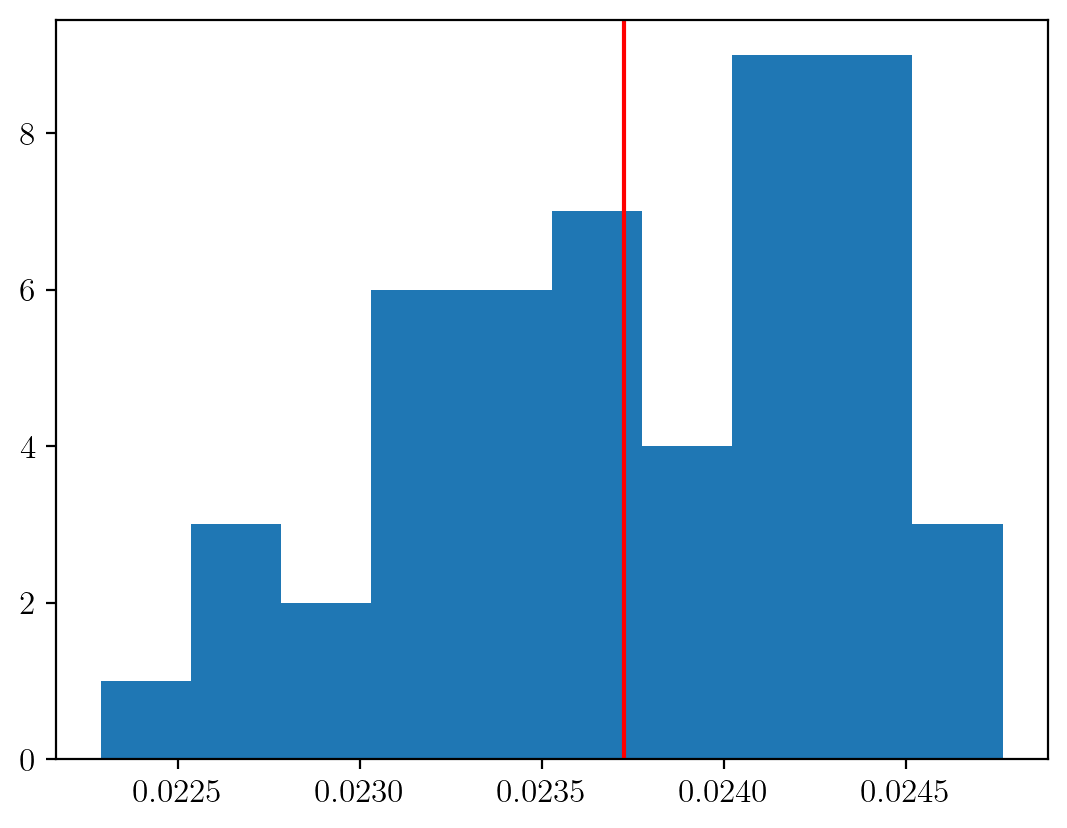

In [23]:

plt.hist(B_lams)
plt.axvline(lamss, color='r')
plt.show()

In [24]:
ordering = g_r.df['orderer'].sort_values()
ordering

69677    0.022676
73368    0.022676
73367    0.022676
73366    0.022676
73365    0.022676
           ...   
125      1.000000
124      1.000000
123      1.000000
583      1.000000
582      1.000000
Name: orderer, Length: 74867, dtype: float64

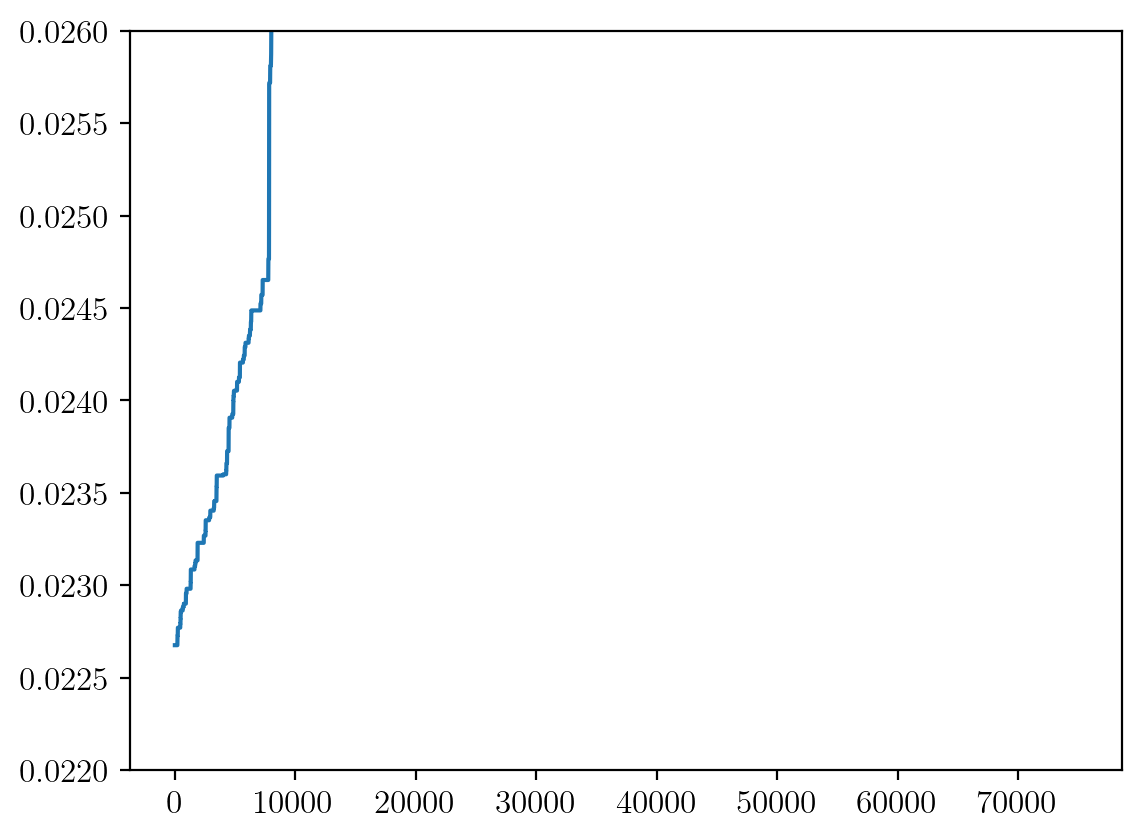

In [25]:
plt.plot(ordering.values)
plt.ylim([0.022, 0.026])
plt.show()

In [26]:
worst_tile = g_r.df.loc[g_r.df['lams'].idxmin()]
worst_tile[['theta0', 'theta1', 'radii0', 'radii1', 'orderer', "alpha0", 'K', 'lams']]

theta0    -1.000391
theta1     0.883789
radii0     0.000391
radii1     0.001367
orderer    0.022676
alpha0     0.024619
K             65536
lams       0.023726
Name: 62164, dtype: object

In [28]:
np.searchsorted(ordering, worst_tile['orderer']), ordering.shape

(0, (74867,))

In [29]:
B_worst_tile = [g_r.df.loc[g_r.df[f'B_lams{i}'].idxmin()] for i in range(50)]
[(B_worst_tile[i]['orderer'], np.searchsorted(ordering, B_worst_tile[i]['orderer'])) for i in range(50)]

[(0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 

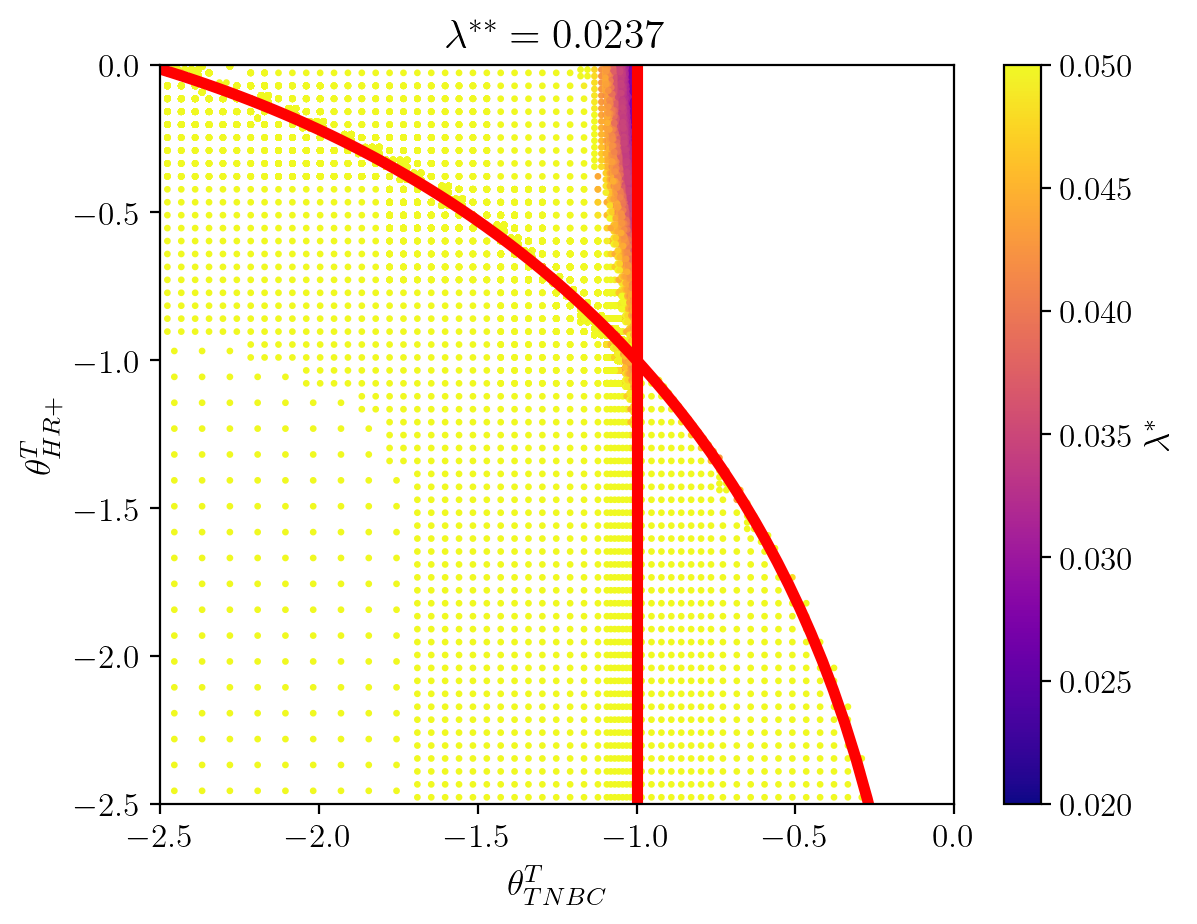

In [31]:
theta = g_r.get_theta()
p = expit(theta)
f = model.true_frac_tnbc
ptt = expit(np.linspace(-2.5, theta[:,1].max(), 100))
pht = ((p_tnbc_c * f + p_hrplus_c * (1 - f)) - (ptt * f)) / (1 - f)
plt.scatter(theta[:,0], theta[:,1], c=g_r.df['lams'], s=2, vmin=0.02, vmax=0.05)
plt.axvline(theta_tnbc_c, color='red', linewidth=4)
plt.plot(logit(ptt), logit(pht), color='red', linewidth=4)
cbar = plt.colorbar()
cbar.set_label('$\lambda^{*}$')
plt.xlabel(r'$\theta_{TNBC}^{T}$')
plt.ylabel(r'$\theta_{HR+}^{T}$')
plt.xlim([-2.5, 0.0])
plt.ylim([-2.5, 0.0])
plt.title('$\lambda^{**}='+f'{lamss:.4f}$')
plt.show()

In [45]:
from jax.scipy.special import expit
results = jax.vmap(model.sim, in_axes=(0, None, None, None, None, None))(
    model.unifs[:1000], p_tnbc_c, expit(-1.0), p_hrplus_c, expit(1.0), True
)

lamss = 0.0239
import pandas as pd
df = pd.DataFrame(results)
df['rej_full'] = df['full_stat'] < lamss
df['rej_tnbc'] = df['tnbc_stat'] < lamss
df.head()

,HI_zcombined,full_stat,hypfull_zstat,hypofull_live,hypotnbc_live,hyptnbc_zstat,tnbc_stat,zfull_stage1,zfull_stage2,ztnbc_stage1,ztnbc_stage2,rej_full,rej_tnbc
0,1.677172,0.046754,1.882450,True,False,-1.309097,0.904749,2.161197,0.500988,-1.162869,-0.688474,False,False
1,3.309248,0.000468,3.496170,True,False,0.556655,0.288882,2.410580,2.533751,0.286446,0.500783,True,False
2,3.329800,0.000435,3.522123,True,False,0.332004,0.369943,2.332458,2.648576,0.723627,-0.254103,True,False
3,4.472816,0.000004,4.588161,True,False,0.832550,0.202549,4.098088,2.390551,1.463850,-0.286446,True,False
4,3.792567,0.000075,3.939487,True,False,-0.062377,0.524869,3.160696,2.410580,-0.324657,0.236442,True,False


In [46]:
df.loc[df['rej_tnbc']]

,HI_zcombined,full_stat,hypfull_zstat,hypofull_live,hypotnbc_live,hyptnbc_zstat,tnbc_stat,zfull_stage1,zfull_stage2,ztnbc_stage1,ztnbc_stage2,rej_full,rej_tnbc
38,4.930005,4.111376e-07,5.044601,True,False,2.680559,0.003675,4.132424,3.001720,1.951800,1.839083,True,True
183,4.616590,1.950487e-06,4.753480,True,False,2.279196,0.011328,3.415073,3.307364,1.313631,1.909640,True,True
244,5.784158,3.643824e-09,5.889882,True,False,2.478750,0.006592,4.488641,3.840910,2.003132,1.502349,True,True
292,5.603102,1.052749e-08,5.746051,True,False,2.382713,0.008593,3.257502,4.868642,1.366533,2.003132,True,True
317,6.534589,3.189220e-11,6.634014,True,False,2.265775,0.011733,4.821160,4.560752,1.549194,1.655096,True,True
374,5.952938,1.316859e-09,6.063214,True,False,2.202515,0.013814,4.286187,4.288493,1.729186,1.385641,True,True
395,5.517431,1.719954e-08,5.643636,True,False,2.017920,0.021800,3.728770,4.252536,0.788178,2.065591,True,True
454,6.419673,6.828360e-11,6.550988,True,False,2.708091,0.003384,3.572131,5.692366,0.487950,3.341870,True,True
482,5.922977,1.580822e-09,6.055137,True,False,2.500945,0.006193,3.547251,5.016005,2.223239,1.313631,True,True
501,4.566278,2.482299e-06,4.713284,True,False,2.099207,0.017899,3.158673,3.506918,1.655096,1.313631,True,True
